In [1]:
"""Reverse time continuation dataset"""
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import interpolate
import numpy as np
from einops import rearrange
from wavebench import wavebench_dataset_path
from wavebench.utils import absolute_file_paths


helmholtz_dataset_dir = os.path.join(wavebench_dataset_path, "time_harmonic/")


In [2]:
# os.path.join(helmholtz_dataset_dir, 'model')

In [3]:
# dataset_name = 'GRF_7Hz'

In [4]:
# input_data = sorted(absolute_file_paths(os.path.join(helmholtz_dataset_dir, dataset_name, 'model')))
# target_data = sorted(absolute_file_paths(os.path.join(helmholtz_dataset_dir, dataset_name, 'data')))

In [27]:
class HelmholtzDataset(Dataset):
  """The time0harmonic Helmholtz dataset

  Args:
      dataset_name (str): can be `GRF_7Hz` or `GRF_15Hz`.
          Default to `GRF_7Hz`.
      sidelen: the side length of the input and target images.
          Default to 128. For lengths other than 128, the images will be
          interpolated to the desinated sidelen.
  """
  def __init__(self,
               dataset_name='GRF_7Hz',
               sidelen=128):
    super(HelmholtzDataset, self).__init__()

    self.sidelen = sidelen

    input_data_paths = sorted(
      absolute_file_paths(
        os.path.join(helmholtz_dataset_dir, dataset_name, 'model')))
    target_data_paths = sorted(
      absolute_file_paths(
        os.path.join(helmholtz_dataset_dir, dataset_name, 'data')))

    input_data = np.concatenate(
      [np.array(np.load(data, mmap_mode='r')) for data in input_data_paths])
    target_data = np.concatenate(
      [np.array(np.load(data, mmap_mode='r')) for data in target_data_paths])


    input_data = 1e-3 * torch.from_numpy(
        input_data).type(torch.FloatTensor)
    target_data = torch.from_numpy(
        target_data).type(torch.FloatTensor)

    input_data = rearrange(input_data, 'n h w -> n 1 h w')

    target_data = rearrange(target_data, 'n h w -> n 1 h w')

    if sidelen != 128:
      input_data = interpolate(input_data, size=[sidelen, sidelen],
                                mode='bicubic')
      target_data = interpolate(target_data, size=[sidelen, sidelen],
                          mode='bicubic')

    self.input_data = input_data
    self.target_data = target_data
    self.len = input_data.shape[0]

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.input_data[idx], self.target_data[idx]


def get_dataloaders_helmholtz(
      dataset_name='GRF_7Hz',
      train_batch_size=1,
      test_batch_size=1,
      train_fraction=0.9,
      sidelen=128,
      num_workers=1):
  """Prepare loaders of the thick line reverse time continuation dataset.

  Args:
      medium_type: can be `gaussian_lens` or `gaussian_random_field`.
      train_batch_size (int, optional): batch size of training.
          Defaults to 1.
      test_batch_size (int, optional): batch size of testing.
          Defaults to 1.
      train_fraction (float, optional): fraction of data for training.
          Defaults to 0.9.
      sidelen (int, optional): side length of the data. Defaults to 128.
      num_workers (int, optional): number of workders. Defaults to 1.

  Returns:
      dataloaders: a dictionary of dataloaders for training,
          evaluation, and testing
  """
  dataset = HelmholtzDataset(
      dataset_name=dataset_name,
      sidelen=sidelen
      )

  test_fraction = round(1 - train_fraction, 1)

  subsets = torch.utils.data.random_split(
      dataset, [train_fraction, test_fraction],
      generator=torch.Generator().manual_seed(42))

  image_datasets = {
      'train': subsets[0],
      'test': subsets[1]}

  batch_sizes = {
      'train': train_batch_size,
      'test': test_batch_size}

  dataloaders = {
      x: DataLoader(
          image_datasets[x], batch_size=batch_sizes[x],
          shuffle=(x == 'train'), pin_memory=True,
          num_workers=num_workers) for x in ['train', 'test']}
  return dataloaders



In [28]:
loaders = get_dataloaders_helmholtz()

In [12]:
import matplotlib.pyplot as plt

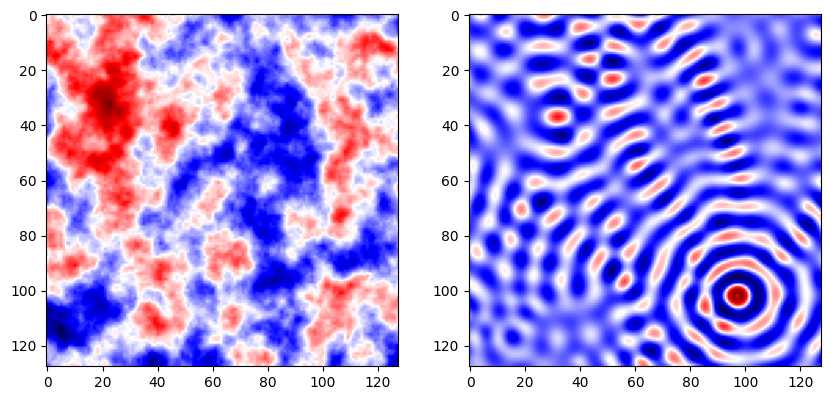

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# x, y = dataset[0]
x, y = next(iter(loaders['train']))
axes[0].imshow(x[0], cmap='seismic')
axes[1].imshow(y[0], cmap='seismic')